In [19]:
# # mount google drive to google colab runtime
# from google.colab import drive
# drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import copy
import shutil

In [11]:
# CROSSING-REPARTITION

def ray_detect(img, point_start, point_end, sign):
    point1_x, point1_y = point_start
    point2_x, point2_y = point_end
    direction_x = point2_x - point1_x
    direction_y = point2_y - point1_y
    if point1_x != point2_x:
        k = float((point1_y - point2_y)/(point1_x - point2_x))
        b = ((point1_y - k*point1_x)+(point2_y - k*point2_x))/2
        if direction_x > 0:
            for x in range(point2_x, img.shape[1]):
                y = int(k*x+b)
                if y>=0 and y<img.shape[0]:
                    if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                        continue
                    else:
                        return int(img[x,y])
        if direction_x < 0:
            for x in range(0, point2_x):
                y = int(k*x+b)
                if y>=0 and y<img.shape[0]:
                    if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                        continue
                    else:
                        return int(img[x,y])
        if direction_y > 0: 
            for y in range(point2_y, img.shape[0]):
                x = int((y-b)/k)
                if x>=0 and x<img.shape[1]:
                    if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                        continue
                    else:
                        return int(img[x,y])
        if direction_y < 0: 
            for y in range(0, point2_y):
                x = int((y-b)/k)
                if x>=0 and x<img.shape[1]:
                    if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                        continue
                    else:
                        return int(img[x,y])
    else:
        x = point1_x
        for y in range(img.shape[0]):
            if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                continue
            else:
                return int(img[x,y])
    return 0

def angle_calculate(a, b, c):
    ang = math.degrees(math.atan2(c[1]-a[1], c[0]-a[0]) - math.atan2(b[1]-a[1], b[0]-a[0]))
    if ang > 180:
        return 360 - ang
    if ang < -180:
        return ang + 360
    if ang < 0:
        return abs(ang)
    return ang

def angle_detection_for_T_shape(img, central_point, match_nonoverlapping_center_list):
    nonoverlapping_tag_list = list(match_nonoverlapping_center_list.keys())
    
    point_0 = match_nonoverlapping_center_list[nonoverlapping_tag_list[0]]
    tag_0 = img[point_0[0], point_0[1]]
    point_1 = match_nonoverlapping_center_list[nonoverlapping_tag_list[1]]
    tag_1 = img[point_1[0], point_1[1]]
    point_2 = match_nonoverlapping_center_list[nonoverlapping_tag_list[2]]
    tag_2 = img[point_2[0], point_2[1]]

    angle_01 = angle_calculate(central_point, point_0, point_1)
    angle_12 = angle_calculate(central_point, point_1, point_2)
    angle_20 = angle_calculate(central_point, point_2, point_0)

    largest_angle = max(angle_01, angle_12, angle_20)

    if largest_angle == angle_01:
        return (tag_0, tag_1, tag_2)
    if largest_angle == angle_12:
        return (tag_1, tag_2, tag_0)
    return (tag_2, tag_0, tag_1)

class UnionFind(object):
    def __init__(self, classes):
        self.__parent = np.concatenate([np.array([0, 1]), classes])
    def find(self, x):
        if x == self.__parent[x]:
            return x
        else:
            self.__parent[x] = self.find(self.__parent[x])
            return self.__parent[x]
    
    def union(self, x, y):
        px, py = self.find(x), self.find(y)
        if (px != py):
            self.__parent[px] = py

def dilated_adjacent(array, overlapping_x, overlapping_y, size = 15):
    global _adj
    tmp = np.zeros(array.shape)
    tmp[overlapping_x, overlapping_y] = array[overlapping_x, overlapping_y].copy()
    
    kernel = np.ones((size, size), np.uint8)
    tmp = cv2.dilate(tmp, kernel, iterations=1)
    tmp[overlapping_x, overlapping_y] -= array[overlapping_x, overlapping_y]
    
    xs, ys = np.where(tmp > 0)
    ret = []
    for x, y in zip(xs, ys):
        ret.append((x, y))
    return ret

def crossing_reconstruct(image, overlapped, non_overlapped):
    ### watershed for crossing areas
    # noice removal
    kernel = np.ones((1,1),np.uint8)
    opening_crossing = cv2.morphologyEx(overlapped,cv2.MORPH_OPEN, kernel)
    # sure foreground area
    sure_fg_crossing = cv2.erode(opening_crossing,kernel,iterations=1)
    # sure background area
    sure_bg_crossing = cv2.dilate(opening_crossing,kernel,iterations=1)
    crossing_edge = cv2.subtract(sure_bg_crossing,sure_fg_crossing)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg_crossing)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    # Now, mark the region of unknown with zero
    markers[crossing_edge == 1] = 0
    markers_crossing = cv2.watershed(image, markers)
    
    # overlapping_class store all the markers values of the overlapping regions
    overlapping_class = [i for i in range(2, np.max(markers_crossing)+1)]
    overlapping_x_class = {}
    overlapping_y_class = {}
    
    # iterate through all markers values
    for i in overlapping_class:
        overlapping_x_class[i], overlapping_y_class[i] = np.where(markers == i)

    # overlapping_center_class stores the midpoint of each crossing area
    overlapping_center_class = {}
    for i in overlapping_class:
        overlapping_center_class[i] = (int(np.mean(overlapping_x_class[i])),int(np.mean(overlapping_y_class[i])))

    # overlapped_areas is a list of points of the overlapping region and the adjacent area with size k
    overlapped_areas = {}
    for i in overlapping_class:
        overlapped_areas[i] = dilated_adjacent(overlapped, overlapping_x_class[i], overlapping_y_class[i], size = 15)
    

    ### Partial watershed treatment of non-overlapping
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(non_overlapped, cv2.MORPH_OPEN, kernel)
    # sure foreground area
    sure_fg = cv2.erode(opening,kernel,iterations=2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=2)
    unknown = cv2.subtract(sure_bg,sure_fg)
    sure_fg = np.uint8(sure_fg)

    # Marker labelling
    hole = sure_fg.copy()
    cv2.floodFill(hole,None,(0,0),255) # find the hole
    hole = cv2.bitwise_not(hole)
    ret, markers = cv2.connectedComponents(hole)
    

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    # Now, mark the region of unknown with zero
    markers[unknown == 1] = 0
    # watershed
    markers = cv2.watershed(image, markers)
    non_overlapping_class = np.arange(2, np.max(markers) + 1)

    # overlapping_match_nonoverlapping store the tag of each overlapping areas with the tags of all adjacent non0overlapping
    # finding matching between overlapped and non-overlapped
    overlapping_match_nonoverlapping = {}
    for i in overlapping_class:
        overlapping_match_nonoverlapping[i] = set()
        for j in overlapped_areas[i]:
            if markers[j[0], j[1]] > 1:
                overlapping_match_nonoverlapping[i].add(markers[j[0], j[1]])  

    # overlapping_match_nonoverlapping_center stores the center of each non-overlapping in the adjacent area for each crossing area
    overlapping_match_nonoverlapping_center = {}
    for i in overlapping_match_nonoverlapping:
        adj_x, adj_y = zip(*overlapped_areas[i])
        adj_x, adj_y = np.array(adj_x), np.array(adj_y)

        overlapping_match_nonoverlapping_center[i] = {}
        for k in overlapping_match_nonoverlapping[i]:
            k_adj_x = adj_x[np.where(markers[adj_x, adj_y] == k)[0]]
            k_adj_y = adj_y[np.where(markers[adj_x, adj_y] == k)[0]]
            c = (int(np.mean(k_adj_x)), int(np.mean(k_adj_y)))
    #             temp_x, temp_y = np.where(markers == k)
    #             c = (int(np.mean(temp_x)),int(np.mean(temp_y)))
            overlapping_match_nonoverlapping_center[i][k] = c

    # UnionFind for combination
    uf = UnionFind(non_overlapping_class)

    output = copy.deepcopy(markers)
    for i in overlapping_match_nonoverlapping:
        temp_area = np.ones(markers.shape)
        for (x, y) in overlapped_areas[i]:
            temp_area[x, y] = markers[x, y]
        for kk in overlapping_match_nonoverlapping_center[i]:
            x = overlapping_match_nonoverlapping_center[i][kk][0]
            y = overlapping_match_nonoverlapping_center[i][kk][1]
        x = overlapping_center_class[i][0]
        y = overlapping_center_class[i][1]

        # if the overlapping region is a T-shape then checking the angle, other wise using ray detection in a cycle
        if(len(overlapping_match_nonoverlapping_center[i]) != 3):
            for j in overlapping_match_nonoverlapping_center[i]:
                tag = ray_detect(temp_area, overlapping_match_nonoverlapping_center[i][j], overlapping_center_class[i], j)
                if tag in overlapping_match_nonoverlapping_center[i]:
                    uf.union(tag, j)
        else:
            tag1, tag2, tag3 = angle_detection_for_T_shape(temp_area, overlapping_center_class[i], overlapping_match_nonoverlapping_center[i])
            uf.union(int(tag1), int(tag2))


    chromosome = {}  # dictionary key is non-overlap class for chromosome, value is overlapping region class

    for tag in non_overlapping_class:
        output[output == tag] = uf.find(tag)
        chromosome[uf.find(tag)] = []
    
    for i in overlapping_class:
        for j in non_overlapping_class:
            if j in overlapping_match_nonoverlapping[i] and i not in chromosome[uf.find(j)]:
                chromosome[uf.find(j)].append(i)  
    
    cp_image = []
    for i in chromosome:
        mask = np.zeros(output.shape)
        mask[(output == i)] = 1
        for j in chromosome[i]:
            mask[markers_crossing == j] = 1
        cp_image.append(mask)
        
    return cp_image

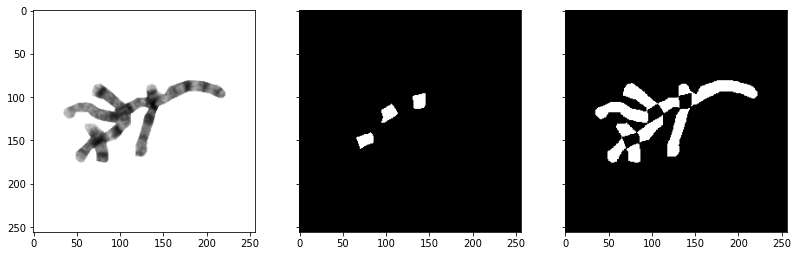

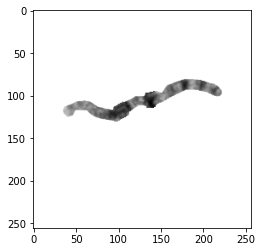

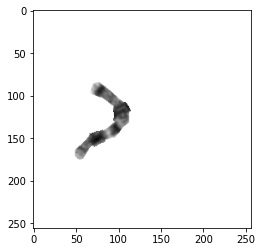

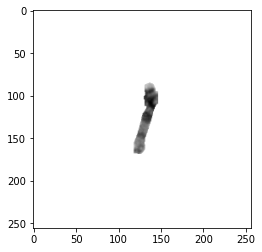

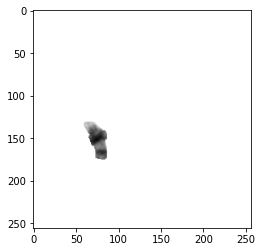

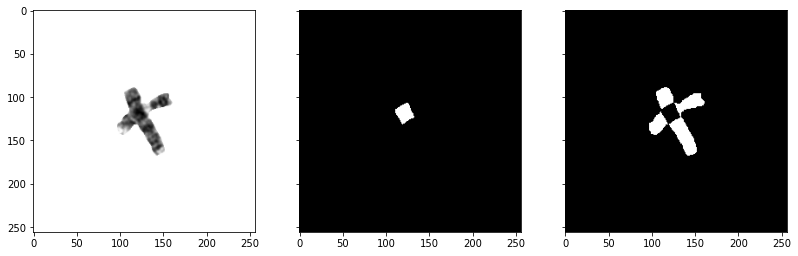

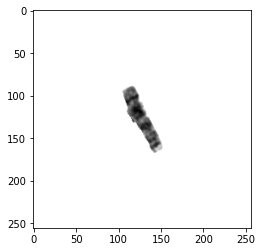

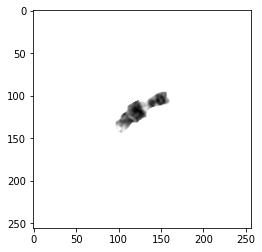

In [12]:
# crossing-partition
INPUT_PATH = 'output region-guided UNet++'
OUTPUT_PATH = 'output crossing-partition'
IMG_SIZE = 256

outputFolderNames = os.listdir(OUTPUT_PATH)
for folder in outputFolderNames:
    shutil.rmtree(os.path.join(OUTPUT_PATH, folder))

inputFolderNames = os.listdir(INPUT_PATH)

for i in range(len(inputFolderNames)):
    folder = inputFolderNames[i]

    os.path.join(INPUT_PATH, folder, "original.png")
    os.path.join(INPUT_PATH, folder, "overlapped.png")
    os.path.join(INPUT_PATH, folder, "non_overlapped.png")

    image = cv2.imread(os.path.join(INPUT_PATH, folder, "original.png"))
    overlapped = cv2.imread(os.path.join(INPUT_PATH, folder, "overlapped.png"), 0)
    non_overlapped = cv2.imread(os.path.join(INPUT_PATH, folder, "non_overlapped.png"), 0)

    overlapped[overlapped < 100] = 0
    overlapped[overlapped >= 100] = 1
    non_overlapped[non_overlapped < 100] = 0
    non_overlapped[non_overlapped >= 100] = 1
    non_overlapped[overlapped == 1] = 0

    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(4.5*3,4.5))
    # plt.subplots(1, 4, sharex=True, sharey=True, figsize=(18,4.5))
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(overlapped, cmap='gray')
    ax[2].imshow(non_overlapped, cmap='gray')
    # fig.tight_layout()
    plt.show()

    output = crossing_reconstruct(image, overlapped, non_overlapped)

    output_path = os.path.join(OUTPUT_PATH, str(i))
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    cv2.imwrite(os.path.join(output_path, "crossing_" + str(i)+".png"), image)

    try:
        num = len(output)
        
        for t in range(num):
            mask = output[t]
            img = copy.deepcopy(image)
            new_mask = np.zeros((IMG_SIZE, IMG_SIZE))
            for i in range(0, IMG_SIZE):
                for j in range(0, IMG_SIZE):
                    if(mask[i,j] == 1):
                        for x in range(-1,2):
                            for y in range(-1,2):
                                try:
                                    new_mask[i+x,j+y] = 1
                                except:
                                    continue
            kernel = np.ones((3,3),np.uint8)
            new_mask = cv2.morphologyEx(new_mask, cv2.MORPH_CLOSE, kernel)

            img[(new_mask == 0)] = [255, 255, 255]
            cv2.imwrite(os.path.join(output_path, str(t)+".png"), img)
            plt.figure()
            plt.imshow(img)

    except:
        raise "error(fail to partition)"